<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019-grad-work/blob/MSFT-10yr/MSFT/daily10y/04-lstm1_multivar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Многомерная модель на LSTM* (1 слой)

В качестве признаков используются цены, объём торгов и некоторое число индикаторов (всего 18 признаков)

In [0]:
import os
import glob
import datetime
import pickle

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
from pandas_datareader import data as pdr

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [6]:
import tensorflow as tf
# tf.test.is_gpu_available()
tf.__version__

'2.0.0'

In [0]:
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Flatten, ReLU, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Nadam

In [0]:
from mdp import TimeSeries
from mdp import MarketData
from mdp import MovingWindowFeatures
from mdp import ClassificationGenerator, RegressionGenerator, MultitaskGenerator
from mdp import invert_log_ret

import mdp.utils as utils
import mdp.plotHelpers as plotHelpers

In [0]:
import importlib

import mdp

importlib.reload(mdp)
importlib.reload(mdp.datasetGenerator)
importlib.reload(mdp.marketData)
importlib.reload(mdp.movingWindowFeatures)
importlib.reload(mdp.timeSeries)
importlib.reload(mdp.plotHelpers)
importlib.reload(mdp.utils);

# *Параметры*

In [0]:
INSTRUMENT = 'MSFT' # Microsoft corp
START_FROM = '2008-11-14'
WINDOW_SIZE = 30
FORECAST_OFFSET=1
BATCH_SIZE = 32
VAL_SPLIT = '2019-01-01'
TEST_SPLIT = '2019-06-01'
FORCE_TRAIN = True

# *Исходные данные*

Загрузка данных и вычисление индикаторов.

In [0]:
instr = MarketData.create_from_tiingo(INSTRUMENT, start=START_FROM)

In [12]:
instr.feature_names

['o',
 'h',
 'l',
 'c',
 'v',
 'ema14',
 'ema30',
 'macd',
 'macd_signal',
 'rsi14',
 'bband20_upper',
 'bband20_middle',
 'bband20_lower',
 'willr14',
 'stochk',
 'stochd',
 'adline',
 'adosc']

## Целевая переменная

Цена закрытия.

In [0]:
orig_target = instr.c

In [0]:
def plot_transformed_series(instrument, series, orig_display_name, transformed_display_name):
    plotHelpers.plot_transformed_timeseries(
        instrument.instrument,
        series,
        title_orig = orig_display_name,
        xlabel_orig = 'Date',
        ylabel_orig = orig_display_name,
        title_transformed = transformed_display_name,
        xlabel_transformed = 'Date',
        ylabel_transformed = transformed_display_name
    )

Переходим к логарифмической доходности.

In [0]:
transformed_target = instr.c.transform(transforms={'ratios' : {}, 'ln' : {}})

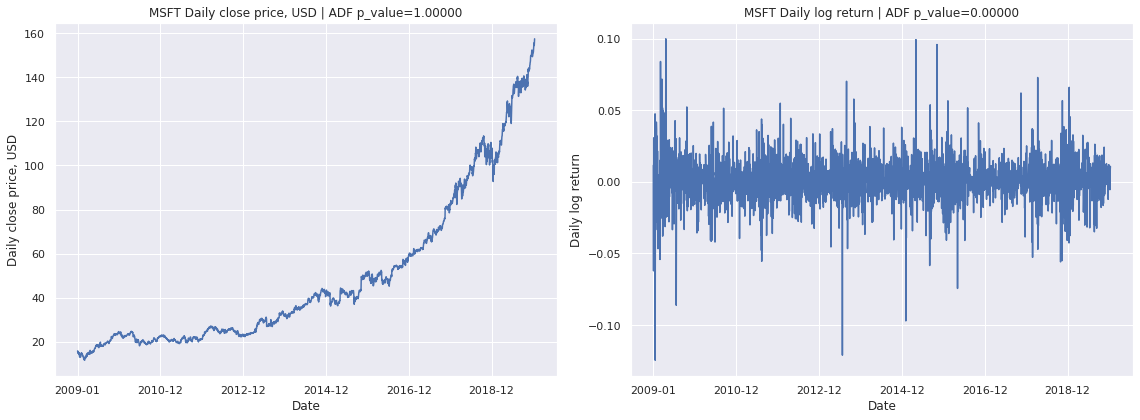

In [16]:
plot_transformed_series(instr,
                        transformed_target,
                        'Daily close price, USD', 'Daily log return')

## Трансформация признаков

Приведение временных рядов к стационарности.

In [0]:
def make_feature_selector():
    price_transformer = lambda: {'ratios': {}, 'ln': {}}
    diff_transformer = lambda o: {'diffs': {'order': o}}
    identity_transformer = lambda: {}
    feature_transformations = {
        'o': price_transformer(),
        'h': price_transformer(),
        'l': price_transformer(),
        'c': price_transformer(),
        'v': diff_transformer(1),
        'ema14': diff_transformer(1),
        'ema30': diff_transformer(1),
        'macd': diff_transformer(1),
        'macd_signal': diff_transformer(1),
        'rsi14': diff_transformer(1),
        'bband20_upper': diff_transformer(1),
        'bband20_middle': diff_transformer(1),
        'bband20_lower': diff_transformer(1),
        'willr14': identity_transformer(),
        'stochd': identity_transformer(),
        'stochk': identity_transformer(),
        'adline': diff_transformer(1),
        'adosc': diff_transformer(1)
    }
    return feature_transformations

In [0]:
instr_transformed = instr.select_transform(make_feature_selector())

In [0]:
transformed_target = instr_transformed.c

## Обучающая, валидационная и тестовая выборки

In [20]:
instr_train, instr_val_test = instr_transformed.train_test_split(VAL_SPLIT, window_size=WINDOW_SIZE,
                                                                 scaler=StandardScaler)
#                                                                  scaler=MinMaxScaler,
#                                                                  scaler_kwargs={'feature_range': (-1, 1)})

instr_val, instr_test = instr_val_test.train_test_split(TEST_SPLIT, window_size=WINDOW_SIZE, scaler=None)

len(instr_train), len(instr_val), len(instr_test)

(2514, 134, 172)

Все отмасштабированные признаки на одном графике (для валидационного датасета):

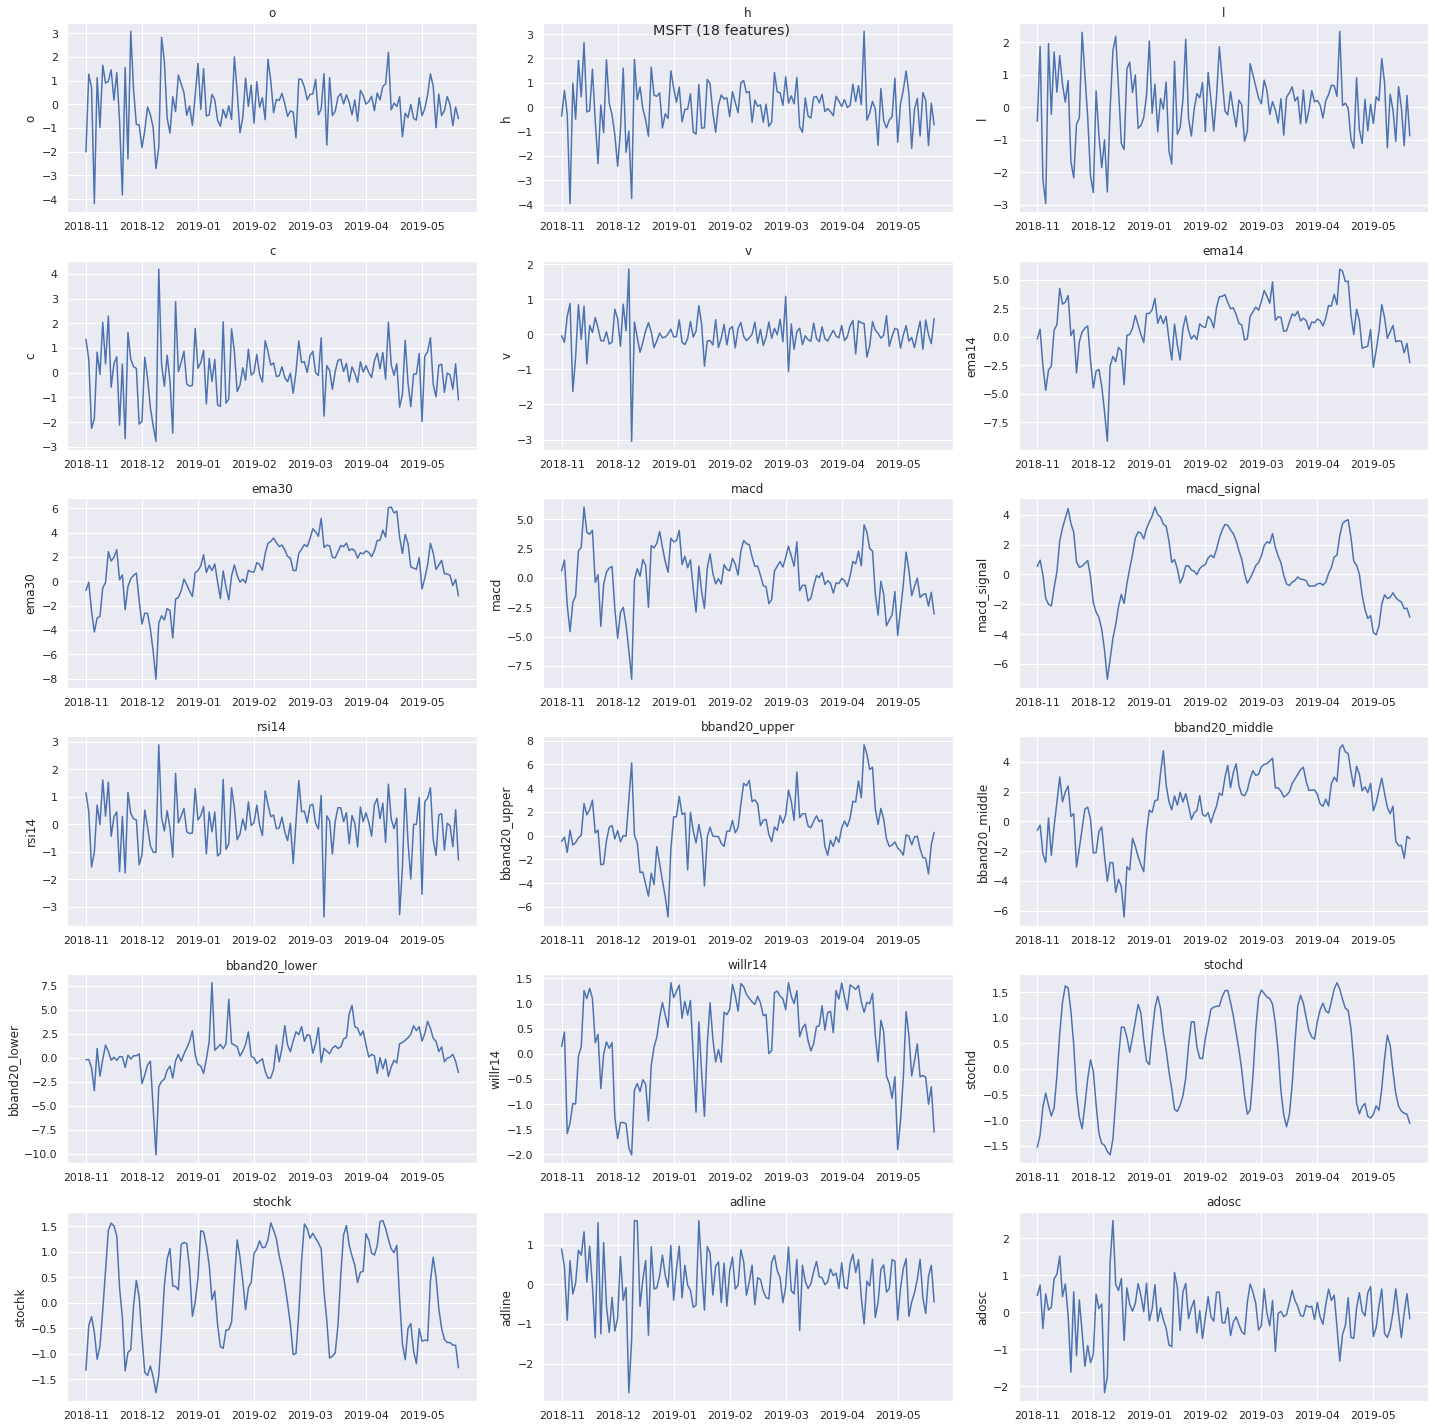

In [21]:
plotHelpers.plot_all_features(instr_val)

## Признаки - скользящие окна

In [22]:
train_mwf = MovingWindowFeatures.create(instr_train.c, [instr_train], instr_train.feature_names, window_size=WINDOW_SIZE)
val_mwf = MovingWindowFeatures.create(instr_val.c, [instr_val], instr_val.feature_names, window_size=WINDOW_SIZE)
test_mwf = MovingWindowFeatures.create(instr_test.c, [instr_test], instr_test.feature_names, window_size=WINDOW_SIZE)

len(instr_train), len(train_mwf), train_mwf.features.shape

(2514, 2484, (2484, 30, 18))

Проверка, что скользящие окна соответствуют исходным данным.

Возьмём произвольный признак и произвольное окно (строка #**41**). Проверим, что данные в точности совпадают:

In [23]:
def check_data(md, mwf, row):
    col = np.random.randint(len(mwf.feature_names))
    feature = mwf.feature_names[col]
    check = (getattr(md, feature).data[row:row + mwf.window_size] == mwf.features[row, :, col]).all()
    assert check
    return feature, check

check_data(instr_train, train_mwf, 41)

('ema30', True)

# *Модели*

Модель с одним LSTM слоем.

In [0]:
def build_lstm_layers(input_shape, latent_dim=16):
    # формат входа: матрица (окно; признак)
    inp = Input(input_shape, name='input')

    lstm = LSTM(latent_dim, return_sequences=True,
                    recurrent_dropout=0.2, dropout=0.2,
                    bias_initializer='he_uniform',
                    bias_regularizer=L1L2(0.01, 0.02),
                    kernel_regularizer=L1L2(0.01, 0.02),
                    recurrent_regularizer=L1L2(0.01, 0.02)
               )(inp)
    
    lstm = Flatten()(lstm)
    
    return inp, lstm

#### Пути сохранения моделей:

In [0]:
model_path_root = 'models'
model_type_name = 'lstm1_multivar'

def make_model_save_dir(path_root, type_name, class_name):
    save_dir = os.path.join(path_root, type_name, class_name)
    os.makedirs(save_dir, exist_ok=True)
    return save_dir

#### Общие коллбэки:

In [0]:
# уменьшение learning rate в случае, если loss не изменяется
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

# уменьшение learning rate в 2 раза каждую 5-ю эпоху
def lr_decay(e, lr):
    return lr * (1 - 0.5 * (0 == (e + 1) % 5))

lr_scheduler = LearningRateScheduler(schedule=lr_decay, verbose=1)

## Задача регрессии

Непосредственное прогнозирование цены следующего периода.

In [0]:
train_regr_gen = RegressionGenerator.create(train_mwf, batch_size=BATCH_SIZE)
val_regr_gen = RegressionGenerator.create(val_mwf, batch_size=BATCH_SIZE, shuffle=False)
test_regr_gen = RegressionGenerator.create(test_mwf, batch_size=BATCH_SIZE, shuffle=False)

Следующие числа соответствуют значению параметра `steps_per_epoch` метода [`fit_generator`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit_generator "tf.keras.layers.SimpleRNN &nbsp;|&nbsp; TensorFlow Core r2.0") - то есть это число батчей, которые генератор выдаст за одну эпоху обучения (если класс генератора поддерживает метод `len()`, то данный параметр можно не указывать).

In [28]:
len(train_regr_gen), len(val_regr_gen), len(test_regr_gen)

(78, 4, 5)

Один сэмпл данных представляет собой матрицу размером *(длина окна; число признаков)*

In [29]:
train_regr_gen.input_shape

(30, 18)

### Модель для задачи регрессии

In [0]:
model_class_name = 'regression'

In [0]:
def build_regression_model(input_shape):
    inp, lstm = build_lstm_layers(input_shape, latent_dim=64)

    regr = Dense(128)(lstm)
    regr = LeakyReLU()(regr)
    regr = BatchNormalization()(regr)
    regr = Dropout(0.5)(regr)
    regr = Dense(1, activation='linear', name='regr')(regr)

    return Model(inputs=[inp], outputs=[regr])

In [0]:
multivariate_regression_lstm = build_regression_model(train_regr_gen.input_shape)

model_save_dir = make_model_save_dir(model_path_root, model_type_name, model_class_name)

#### Оптимизатор:
[`Nadam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam) (*Adam with Nestrov momentum*).

In [0]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

#### Дополнительные коллбэки:

In [0]:
checkpointer = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,
                               filepath=os.path.join(model_save_dir, '{epoch:02d}.hdf5'))

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1)

#### Функция потерь:

В качестве функции потерь будем использовать [MSE](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MSE) (чтобы штрафовать за большие отклонения). Xотя хорошая функция потерь в контексте темы данной задачи - это [вопрос сложный](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC3.ipynb). В частности, здесь нам, очевидно, помимо абсолютного значения отклонения также важен его знак.

In [35]:
multivariate_regression_lstm.compile(optimizer=optimizer,
                                     loss={'regr': 'mse'},
                                     metrics={'regr': 'mae'})

multivariate_regression_lstm.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 30, 18)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 30, 64)            21248     
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               245888    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

#### Обучение:

In [36]:
regr_history = utils.train_model(multivariate_regression_lstm,
                                 model_save_dir, train_regr_gen, val_regr_gen,
                                 callbacks=[reduce_lr, lr_scheduler, checkpointer, earlyStopping],
                                 force_train=FORCE_TRAIN, verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/32
77/78 [============================>.] - ETA: 0s - loss: 16.3589 - mae: 1.3764
Epoch 00001: val_loss improved from inf to 10.79279, saving model to models/lstm1_multivar/regression/01.hdf5
78/78 [==============================] - 6s 82ms/step - loss: 16.3036 - mae: 1.3747 - val_loss: 10.7928 - val_mae: 0.7104

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/32
77/78 [============================>.] - ETA: 0s - loss: 10.2763 - mae: 1.1286
Epoch 00002: val_loss improved from 10.79279 to 7.29980, saving model to models/lstm1_multivar/regression/02.hdf5
78/78 [==============================] - 6s 81ms/step - loss: 10.2769 - mae: 1.1296 - val_loss: 7.2998 - val_mae: 0.7331

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/32
77/78 [============================>.] - ETA: 0s - loss: 7.2480 - mae: 0.9837
Epoch 000

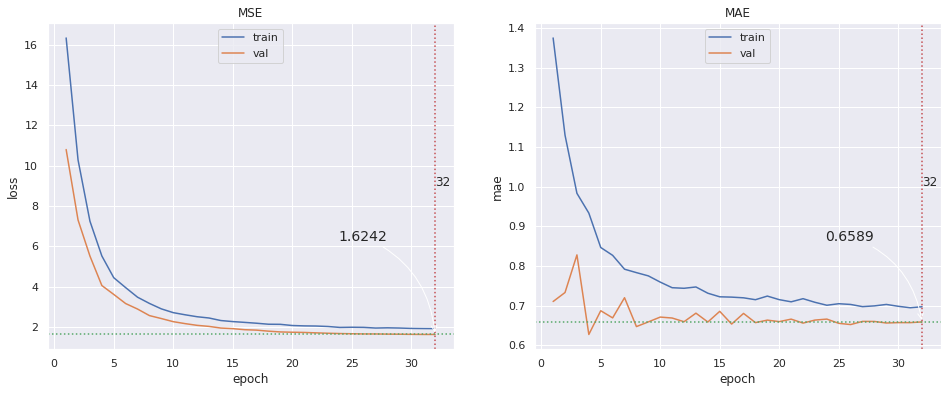

In [37]:
def plot_regr_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plotHelpers.plot_train_history(ax[0], hist, 'MSE', 'loss', 'val_loss')
    plotHelpers.plot_train_history(ax[1], hist, 'MAE', 'mae', 'val_mae')
    
plot_regr_history(regr_history);

### Прогноз задачи регрессии

*Судя по всему, просто выходит на модель случайного блуждания*

In [0]:
# загружаем последнюю эпоху с минимальным лоссом
multivariate_regression_lstm.load_weights(sorted(glob.glob(os.path.join(model_save_dir,'*.hdf5')))[-1])

#### На тесте:

In [39]:
pred_log_ret_test = multivariate_regression_lstm.predict_generator(test_regr_gen, verbose=1)

5/5 [==============================] - 0s 27ms/step


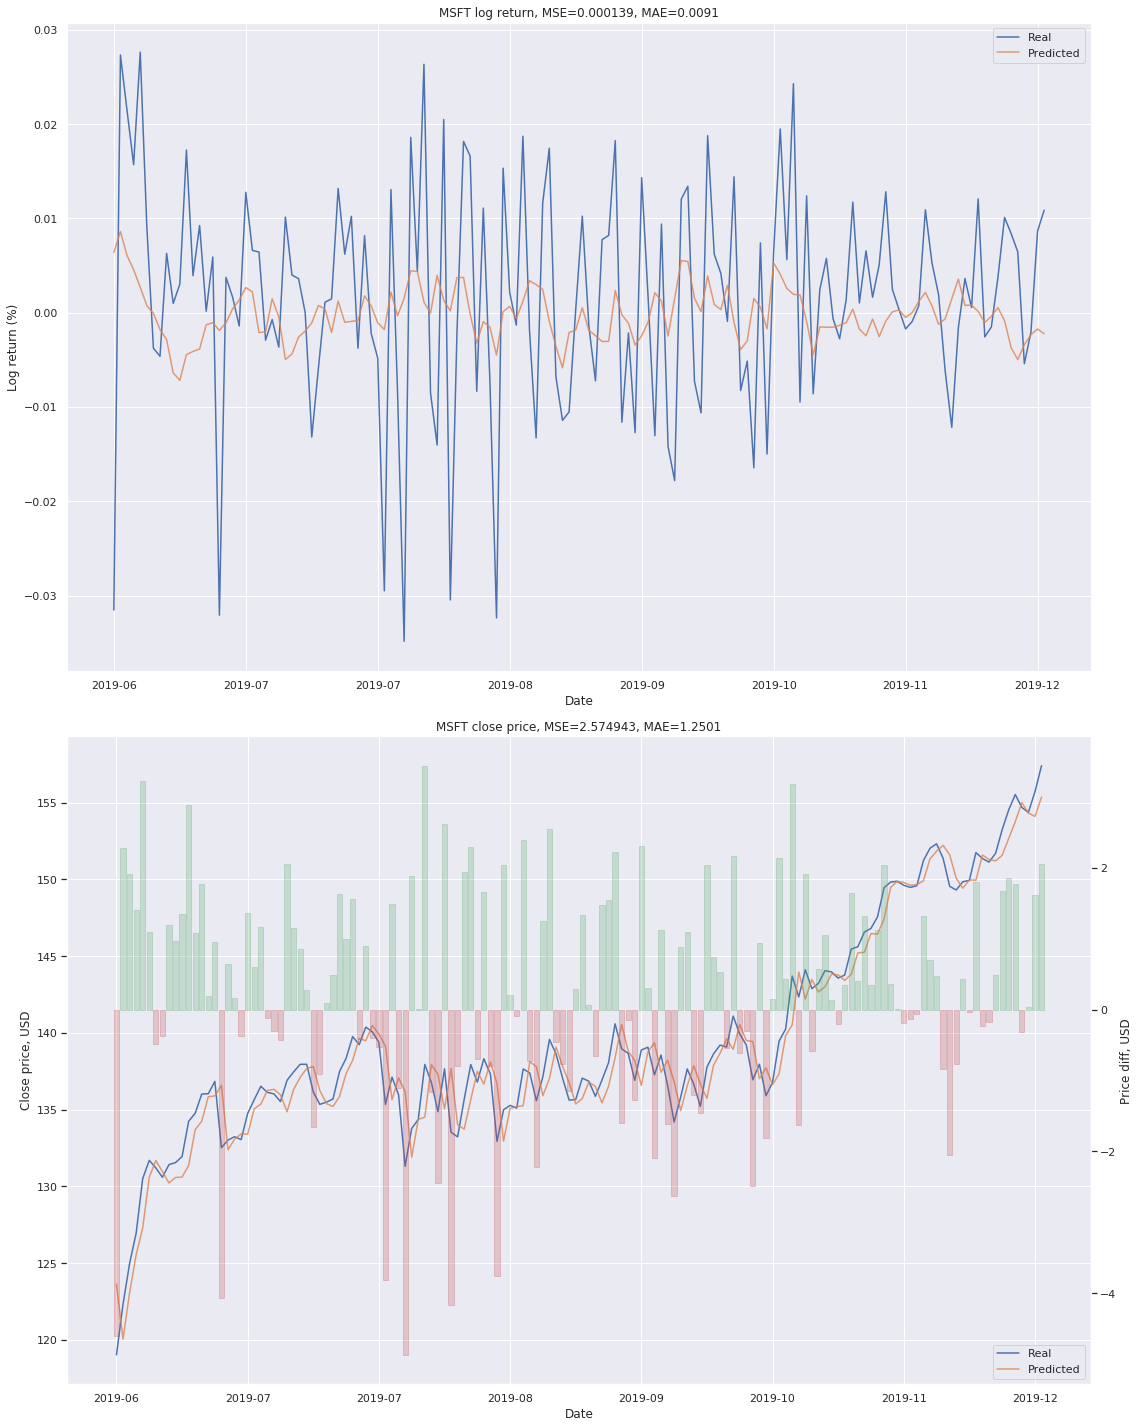

In [40]:
plotHelpers.plot_regr_predictions(orig_target, instr_test, pred_log_ret_test, figsize=(16, 20))

## Задача классификации

Прогнозируем направление изменения цены по сравнению с предыдущим периодом (**0** - снижение, **1** - рост).

In [0]:
model_class_name = 'classification'

In [0]:
train_clf_gen = ClassificationGenerator.create(train_mwf, batch_size=BATCH_SIZE)
val_clf_gen = ClassificationGenerator.create(val_mwf, batch_size=BATCH_SIZE, shuffle=False)
test_clf_gen = ClassificationGenerator.create(test_mwf, batch_size=BATCH_SIZE, shuffle=False)

In [0]:
def build_classification_model(input_shape):
    inp, lstm = build_lstm_layers(input_shape, latent_dim=64)

    clf = Dense(128)(lstm)
    clf = LeakyReLU()(clf)
    clf = BatchNormalization()(clf)
    clf = Dropout(0.5)(clf)
    clf = Dense(1, activation='sigmoid', name='clf')(clf)

    return Model(inputs=[inp], outputs=[clf])

In [0]:
multivariate_classification_lstm = build_classification_model(test_clf_gen.input_shape)

model_save_dir = make_model_save_dir(model_path_root, model_type_name, model_class_name)

#### Оптимизатор:

In [0]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

#### Функция потерь:

In [46]:
multivariate_classification_lstm.compile(optimizer=optimizer,
                                         loss={'clf': 'binary_crossentropy'},
                                         metrics={'clf': 'accuracy'})

multivariate_classification_lstm.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 30, 18)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            21248     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               245888    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0   

#### Дополнительные коллбэки:

In [0]:
checkpointer = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,
                               filepath=os.path.join(model_save_dir, '{epoch:02d}.hdf5'))

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1)

#### Обучение:

In [48]:
clf_history = utils.train_model(multivariate_classification_lstm,
                                model_save_dir, train_clf_gen, val_clf_gen,
                                callbacks=[reduce_lr, lr_scheduler, checkpointer, earlyStopping],
                                force_train=FORCE_TRAIN, verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/32
77/78 [============================>.] - ETA: 0s - loss: 11.0827 - accuracy: 0.4907
Epoch 00001: val_loss improved from inf to 6.38263, saving model to models/lstm1_multivar/classification/01.hdf5
78/78 [==============================] - 6s 82ms/step - loss: 11.0231 - accuracy: 0.4911 - val_loss: 6.3826 - val_accuracy: 0.4327

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/32
77/78 [============================>.] - ETA: 0s - loss: 4.5420 - accuracy: 0.5004
Epoch 00002: val_loss improved from 6.38263 to 3.13073, saving model to models/lstm1_multivar/classification/02.hdf5
78/78 [==============================] - 6s 81ms/step - loss: 4.5315 - accuracy: 0.4992 - val_loss: 3.1307 - val_accuracy: 0.5577

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/32
77/78 [============================>.] - ETA: 0s - los

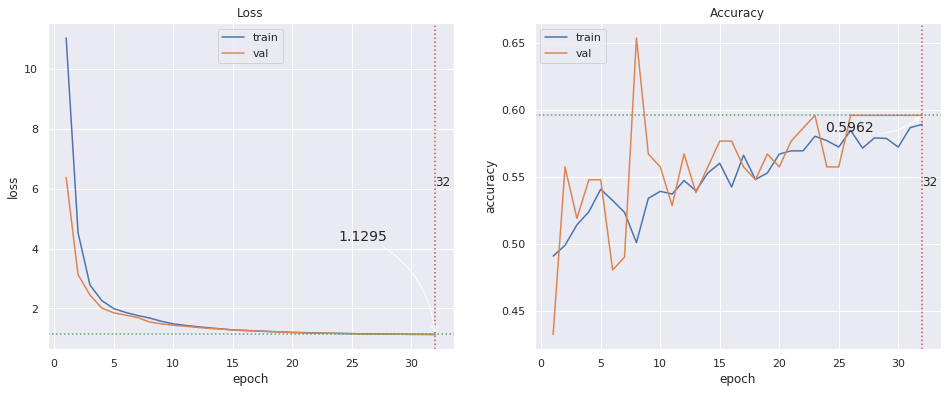

In [49]:
def plot_clf_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plotHelpers.plot_train_history(ax[0], hist, 'Loss', 'loss', 'val_loss')
    plotHelpers.plot_train_history(ax[1], hist, 'Accuracy', 'accuracy', 'val_accuracy')
    
plot_clf_history(clf_history);

### Прогноз задачи классификации

*Разделяющая способность довольно слабая, вероятности обоих классов очень близки к порогу отсечения*.

In [0]:
# загружаем последнюю эпоху с минимальным лоссом
multivariate_classification_lstm.load_weights(sorted(glob.glob(os.path.join(model_save_dir,'*.hdf5')))[-1])

In [51]:
pred_direction_proba = multivariate_classification_lstm.predict_generator(test_clf_gen, verbose=1)

true_direction = test_clf_gen.get_target_direction(test_mwf.target[-len(pred_direction_proba):])

predicted_direction = (np.mean(pred_direction_proba) < pred_direction_proba).astype(np.int)

np.mean(pred_direction_proba)

5/5 [==============================] - 0s 51ms/step


0.48385385

In [52]:
np.unique(true_direction, return_counts=True), \
np.unique(predicted_direction, return_counts=True)

((array([0, 1]), array([62, 80])), (array([0, 1]), array([75, 67])))

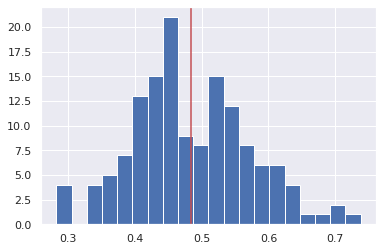

In [53]:
plt.hist(pred_direction_proba, bins=20)
plt.axvline(np.mean(pred_direction_proba), c='r');

In [54]:
print(classification_report(true_direction, predicted_direction))

              precision    recall  f1-score   support

           0       0.47      0.56      0.51        62
           1       0.60      0.50      0.54        80

    accuracy                           0.53       142
   macro avg       0.53      0.53      0.53       142
weighted avg       0.54      0.53      0.53       142



In [55]:
confusion_matrix(true_direction, predicted_direction)

array([[35, 27],
       [40, 40]])

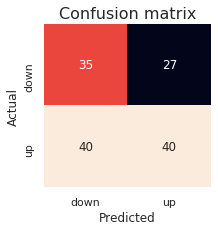

array([[0.46666667, 0.40298507],
       [0.53333333, 0.59701493]])

In [56]:
plotHelpers.show_confusion_matrix(true_direction, predicted_direction, ['down', 'up'])

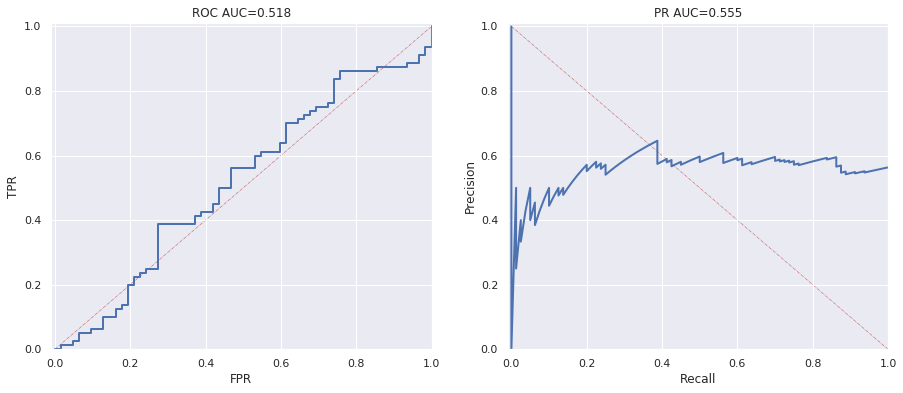

In [57]:
plotHelpers.plot_roc_pr_curves(true_direction, pred_direction_proba)

## Многозадачная модель: одновременно регрессия и классификация

Пытаемся одновременно предсказать и значение цены, и направление изменения, предполагая, что комбинированная ошибка позволит точнее скорректировать веса рекуррентных слоёв.

In [0]:
model_class_name = 'multitask'

In [0]:
train_multi_gen = MultitaskGenerator.create(train_mwf, batch_size=BATCH_SIZE)
val_multi_gen = MultitaskGenerator.create(val_mwf, batch_size=BATCH_SIZE, shuffle=False)
test_multi_gen = MultitaskGenerator.create(test_mwf, batch_size=BATCH_SIZE, shuffle=False)

In [0]:
def build_multitask_model(input_shape):
    inp, lstm = build_lstm_layers(input_shape, latent_dim=64)

    # первый выход: задача регрссии
    regr = Dense(128)(lstm)
    regr = LeakyReLU()(regr)
    regr = BatchNormalization()(regr)
    regr = Dropout(0.5)(regr)
    regr = Dense(1, activation='linear', name='regr')(regr)

    # второй выход: задача классификации
    clf = Dense(128)(lstm)
    clf = LeakyReLU()(clf)
    clf = BatchNormalization()(clf)
    clf = Dropout(0.5)(clf)
    clf = Dense(1, activation='sigmoid', name='clf')(clf)
    
    return Model(inputs=[inp], outputs=[regr, clf])

In [0]:
multivariate_multitask_lstm = build_multitask_model(train_multi_gen.input_shape)

model_save_dir = make_model_save_dir(model_path_root, model_type_name, model_class_name)

#### Оптимизатор:

In [0]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

#### Функция потерь:

In [63]:
multivariate_multitask_lstm.compile(optimizer=optimizer,
                                    loss={'regr': 'mse', 'clf': 'binary_crossentropy'},
                                    loss_weights={'regr': 2., 'clf': 1.},
                                    metrics={'regr': 'mae', 'clf' : 'accuracy'})

multivariate_multitask_lstm.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 30, 18)]     0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 30, 64)       21248       input[0][0]                      
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 1920)         0           lstm_2[0][0]                     
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          245888      flatten_2[0][0]                  
____________________________________________________________________________________________

#### Дополнительные коллбэки:

In [0]:
checkpointer = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,
                               filepath=os.path.join(model_save_dir, '{epoch:02d}.hdf5'))

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1)

#### Обучение:

In [65]:
multitask_history = utils.train_model(multivariate_multitask_lstm,
                                      model_save_dir, train_multi_gen, val_multi_gen,
                                      callbacks=[reduce_lr, lr_scheduler, checkpointer, earlyStopping],
                                      force_train=FORCE_TRAIN, verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/32
77/78 [============================>.] - ETA: 0s - loss: 22.2615 - regr_loss: 3.5809 - clf_loss: 0.9729 - regr_mae: 1.4332 - clf_accuracy: 0.4947
Epoch 00001: val_loss improved from inf to 14.65988, saving model to models/lstm1_multivar/multitask/01.hdf5
78/78 [==============================] - 8s 108ms/step - loss: 22.2129 - regr_loss: 3.5700 - clf_loss: 0.9707 - regr_mae: 1.4330 - clf_accuracy: 0.4952 - val_loss: 14.6599 - val_regr_loss: 0.9149 - val_clf_loss: 0.6854 - val_regr_mae: 0.7618 - val_clf_accuracy: 0.5000

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/32
77/78 [============================>.] - ETA: 0s - loss: 15.8523 - regr_loss: 2.2869 - clf_loss: 0.8630 - regr_mae: 1.1458 - clf_accuracy: 0.5028
Epoch 00002: val_loss improved from 14.65988 to 11.19639, saving model to models/lstm1_multivar/multitask/02.hdf5
78/78 [=================

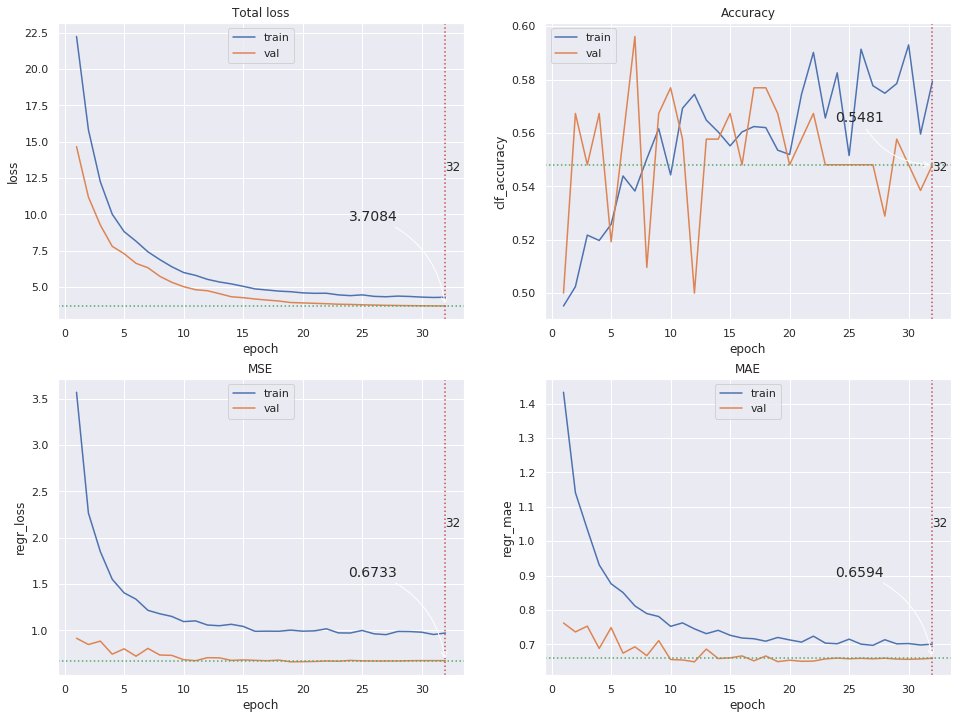

In [66]:
def plot_multitask_history(hist):
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    plotHelpers.plot_train_history(ax[0, 0], hist, 'Total loss', 'loss', 'val_loss')
    plotHelpers.plot_train_history(ax[0, 1], hist, 'Accuracy', 'clf_accuracy', 'val_clf_accuracy')
    plotHelpers.plot_train_history(ax[1, 0], hist, 'MSE', 'regr_loss', 'val_regr_loss')
    plotHelpers.plot_train_history(ax[1, 1], hist, 'MAE', 'regr_mae', 'val_regr_mae')
    
plot_multitask_history(multitask_history);

### Прогноз

In [0]:
# загружаем последнюю эпоху с минимальным лоссом
multivariate_multitask_lstm.load_weights(sorted(glob.glob(os.path.join(model_save_dir,'*.hdf5')))[-1])

#### На тесте:

In [68]:
pred_log_ret, pred_direction_proba = multivariate_multitask_lstm.predict_generator(test_multi_gen, verbose=1)

5/5 [==============================] - 0s 37ms/step


In [69]:
np.set_printoptions(precision=3, suppress=True)

np.column_stack([pred_log_ret, pred_direction_proba])[-10:]

array([[-0.124,  0.565],
       [ 0.017,  0.654],
       [ 0.097,  0.732],
       [ 0.024,  0.685],
       [-0.179,  0.504],
       [-0.289,  0.402],
       [-0.24 ,  0.419],
       [-0.204,  0.49 ],
       [-0.117,  0.541],
       [-0.13 ,  0.517]], dtype=float32)

#### Прогноз задачи регрессии

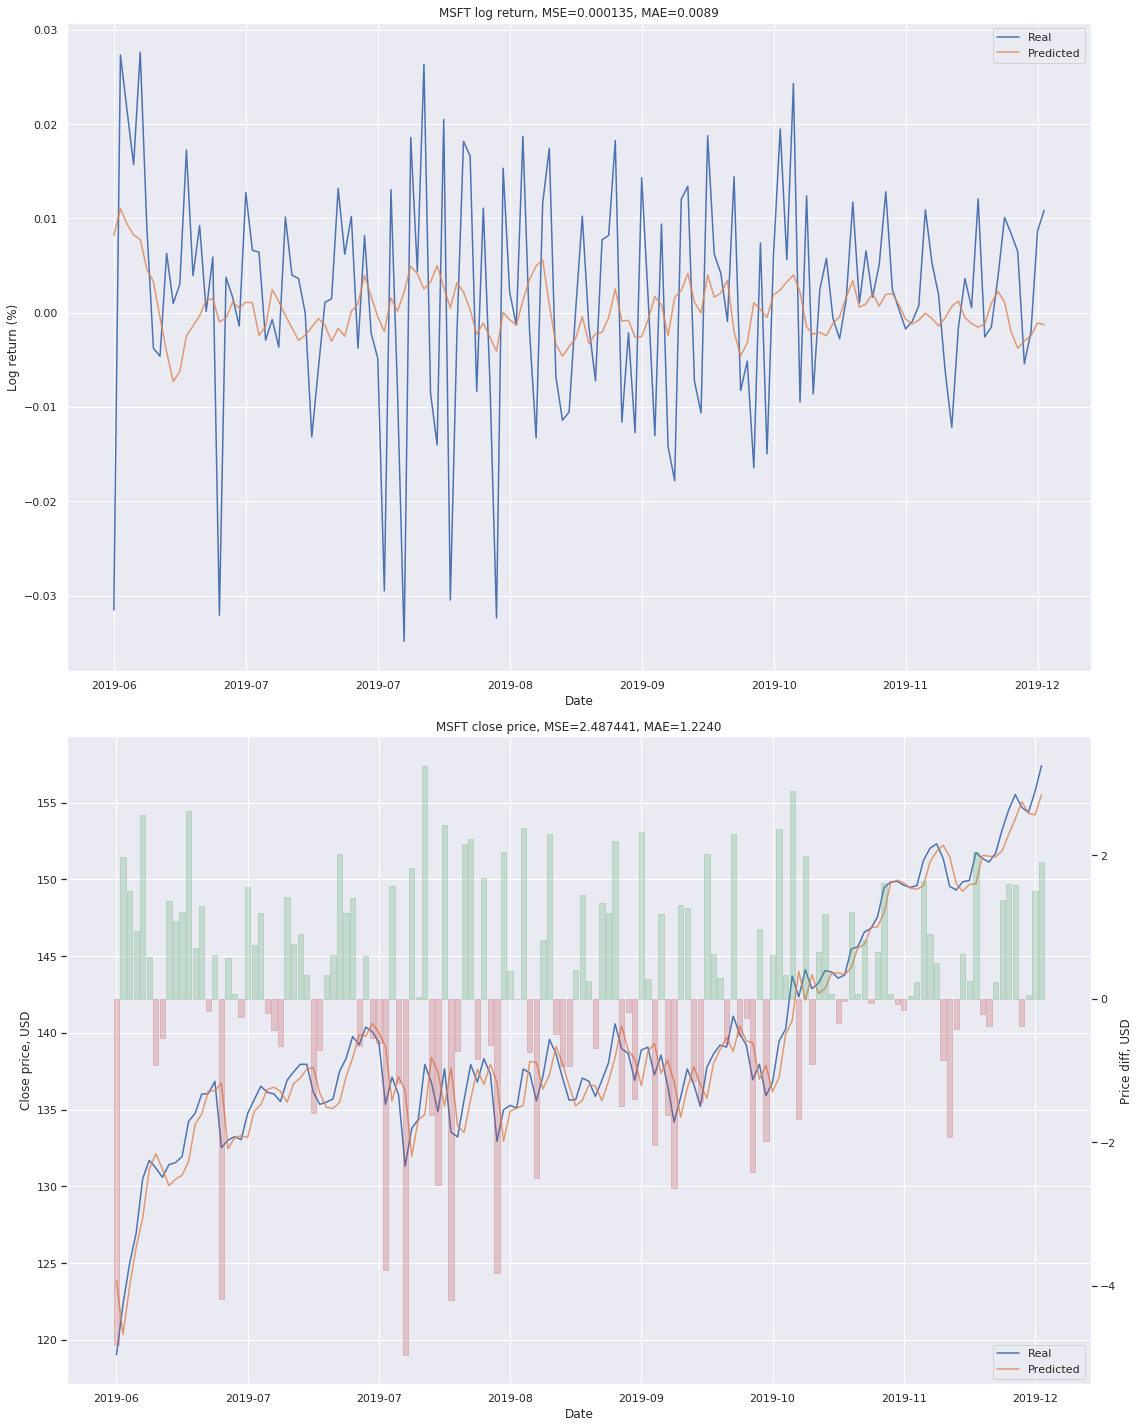

In [70]:
plotHelpers.plot_regr_predictions(orig_target, instr_test, pred_log_ret, figsize=(16, 20))

#### Прогноз задачи классификации

*Качество классификации даже ухудшилось*.

In [71]:
true_direction = test_clf_gen.get_target_direction(test_mwf.target[-len(pred_direction_proba):])

predicted_direction = (np.mean(pred_direction_proba) < pred_direction_proba).astype(np.int)

np.mean(pred_direction_proba)

0.5099065

In [0]:
true_direction = test_multi_gen.get_target_direction(test_mwf.target[-len(pred_direction_proba):])

predicted_direction = (np.mean(pred_direction_proba) < pred_direction_proba).astype(np.int)

In [73]:
np.unique(true_direction, return_counts=True), \
np.unique(predicted_direction, return_counts=True)

((array([0, 1]), array([62, 80])), (array([0, 1]), array([73, 69])))

In [74]:
print(classification_report(true_direction, predicted_direction))

              precision    recall  f1-score   support

           0       0.49      0.58      0.53        62
           1       0.62      0.54      0.58        80

    accuracy                           0.56       142
   macro avg       0.56      0.56      0.56       142
weighted avg       0.57      0.56      0.56       142



In [75]:
confusion_matrix(true_direction, predicted_direction)

array([[36, 26],
       [37, 43]])

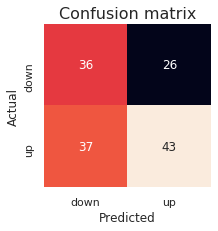

array([[0.493, 0.377],
       [0.507, 0.623]])

In [76]:
plotHelpers.show_confusion_matrix(true_direction, predicted_direction, ['down', 'up'])

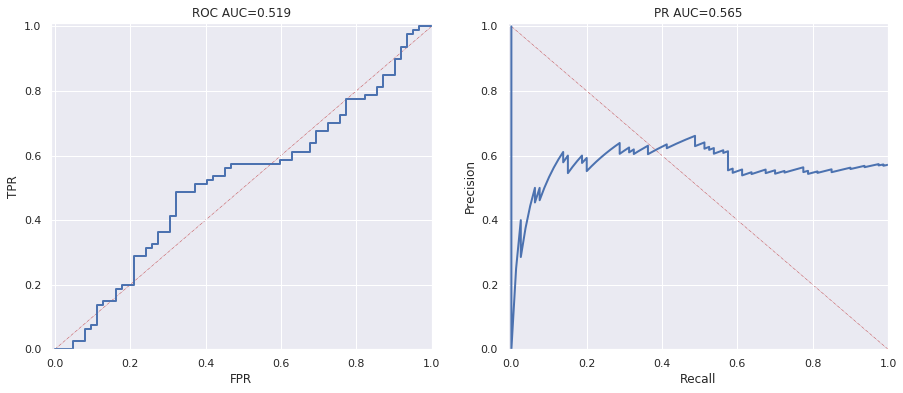

In [77]:
plotHelpers.plot_roc_pr_curves(true_direction, pred_direction_proba)

# Выводы

1.  Размер батча сильно влияет на скорость обучения.
2.  Инициализация весов (`bias_initializer`) в слое **LSTM** оказалась очень важным параметром.
3.  Модель регрессии близка к модели случайного блуждания.
4.  Разделяющая способность модели классификации довольно низкая.
5.  Комбинированная (многозадачная) модель не смогла как-то улучшить качество прогнозирования по сравнению с каждой из двух однозадачных моделей.